# 1. Overview
- 행렬분해(Matrix Factorization)를 기반으로 사용한다.
    - user-item 행렬 데이터를 이용해 잠재요인을 찾아내는데, user-item 행렬을 아래와 같이 분해한다.
    1. user-잠재요인
    2. item-잠재요인
    - 이는 user-item 행렬 데이터의 값을 기반으로 만들어진다.
    - 잠재요인을 활용하여 user가 평가하지 않은 컨텐츠의 점수를 예측하는 것 이다.
- Kakao Tech에서 언급하는 협업 필터링의 대분류 1) 메모리 기반의 접근 방식과 2) 모델 기반의 접근 방식 중에서 2) 모델 기반의 접근 방식에 속한다.
    - Matrix Factorization (i.e. MF) 접근 방식에 이어 Autoencoder를 활용하기도 한다. 하지만 모두 MF의 일반화(Generalization)로 볼 수 있다.

# 2. Data

In [1]:
import pandas as pd
import numpy as np

dir_path = "datas/movielens_small/{}"
rating_data = pd.read_csv(dir_path.format("ratings.csv"))
movie_data = pd.read_csv(dir_path.format("movies.csv"))

In [2]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# 3. Data Preprocessing

## 1. Needed Column Extraction

In [4]:
rating_data.drop('timestamp', axis=1, inplace=True)

crow, ccol = rating_data.shape
print("[count] row : {}, column : {}".format(crow, ccol))
rating_data.head(5)

[count] row : 100004, column : 3


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [5]:
movie_data.drop('genres', axis=1, inplace=True)
movie_data.head(5)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


## 2. Merge ratings - movies 
- 2개의 데이터는 movie 데이터의 movieId(1) - 사용자의 평점 데이터의 movieId(N) 칼럼으로 1:N 구조로 형성되어 있다.

In [6]:
usr_movie_rating = pd.merge(rating_data, movie_data, on="movieId")

crow, ccol = usr_movie_rating.shape
print("[count] row : {}, column : {}".format(crow, ccol))
usr_movie_rating.head()

[count] row : 100004, column : 4


,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


## 3. Generate Pivot Table
- merge된 데이터를 확인해보면 사용자 ID, 영화 ID, 평가점수, 제목 과 같은 구성으로 되어있다.
- 해당의 데이터를 사용자가 index, 영화가 column, 평가점수가 data인 데이터로 바꾸어준다.

In [8]:
usr_movie_pivot = usr_movie_rating.pivot_table('rating', index='userId', columns='title')
usr_movie_pivot.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# NaN 처리
usr_movie_pivot.fillna(0, inplace=True)
usr_movie_pivot.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Latent Factor Collaborative Filtering

## 1. SVD (Singular Value Decomposition)
- M x N 크기의 데이터 행렬 A를 U, 시그마, V^T 의 행렬로 분해한다.
- 이 때, U를 특이 벡터로 이루어진 행렬이라고 부른다. 여기서 특이 벡터는 서로 직교하는 성질을 가지며, 대각 행렬인 시그마의 대각 성분이 원본 행렬의 특이값이다.
- 일반적으로 시그마 행렬은 M x N 의 크기를 가지기 때문에 시그마의 비대각 부분과 대각 원소 중 특이값이 0인 부분도 모두 제거해주며 제거한 부분에 대응되는 U와 V^T의 원소도 같이 제거하여 차원을 줄인 상태로 SVD를 적용할 수 있다. 이를 **TruncatedSVD**라고 부른다.

In [13]:
# Pivot table transposition
movie_user_pivot = usr_movie_pivot.values.T

crow, ccol = movie_user_pivot.shape
print("[count] row : {}, column : {}".format(crow, ccol))
movie_user_pivot

[count] row : 9064, column : 671


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
from sklearn.decomposition import TruncatedSVD

# 영화 - 사용자 구조의 데이터가 
# 각 각의 영화가 12개의 특이값(latent)을 가지고 있는 형태의 행렬로 변환된다.
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(movie_user_pivot)

crow, ccol = matrix.shape
print("[count] row : {}, column : {}".format(crow, ccol))
matrix

[count] row : 9064, column : 12


array([[ 1.22749118e-02,  2.50762131e-03,  1.55478706e-02, ...,
        -2.08236937e-02,  1.01773998e-02, -9.81751993e-03],
       [ 4.23038324e-01, -6.91345368e-03, -4.06772246e-01, ...,
        -8.79276357e-04, -5.07896812e-01, -2.23607888e-01],
       [ 1.66327790e-01,  1.08319670e-01,  6.02892284e-02, ...,
         2.18188504e-01,  7.66180150e-02, -3.54736538e-03],
       ...,
       [ 8.51772029e+00, -3.31479871e+00,  9.03694334e-01, ...,
        -3.11855929e-01,  7.67577698e-01,  2.41202057e+00],
       [ 3.19207068e-01,  3.05397578e-01, -5.41655005e-01, ...,
        -9.62139597e-02, -6.14722091e-01, -2.11413303e-02],
       [ 1.04837791e-01,  2.96769602e-01, -2.18220232e-01, ...,
        -1.92788197e-01,  1.09082333e-01,  9.70373384e-02]])

## 2. Pearson Correlation Coefficient

In [22]:
import numpy as np

corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

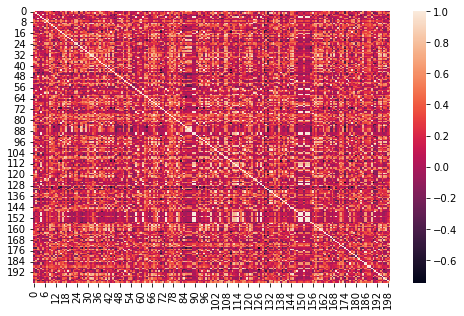

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

corr2 = corr[:200, :200]

plt.figure(figsize=(8,5))
sns.heatmap(corr2)

plt.show()

## 3. Use

In [29]:
# movie title list
movie_title = usr_movie_pivot.columns
movie_title_list = list(movie_title)

movie_title_list[:10]

['"Great Performances" Cats (1998)',
 '$9.99 (2008)',
 "'Hellboy': The Seeds of Creation (2004)",
 "'Neath the Arizona Skies (1934)",
 "'Round Midnight (1986)",
 "'Salem's Lot (2004)",
 "'Til There Was You (1997)",
 "'burbs, The (1989)",
 "'night Mother (1986)",
 '(500) Days of Summer (2009)']

In [52]:
def recommend_movie(title):
    target = movie_title_list.index(title)
    corr_target = corr[target]
    sorted_idx = corr_target.argsort()[::-1]
    result = list(movie_title[sorted_idx])[1:11]
    
    return result

In [53]:
recommend_movie("Toy Story (1995)")

['Sleepers (1996)',
 'Last of the Mohicans, The (1992)',
 'Before Sunrise (1995)',
 'Forrest Gump (1994)',
 'Robin Hood: Prince of Thieves (1991)',
 'Altered States (1980)',
 'Jurassic Park (1993)',
 'Karate Kid, The (1984)',
 'Casino (1995)',
 'Edward Scissorhands (1990)']

## 4. 의미

In [59]:
title = "Toy Story (1995)"

target = movie_title_list.index(title)
corr_target = corr[target]

sorted_idx = corr_target.argsort()[::-1]

top_data = movie_title[sorted_idx[1]]
bottom_data = movie_title[sorted_idx[-1]]

print("추천 상위 영화 : {} / 추천 하위 영화 : {}".format(top_data, bottom_data))

추천 상위 영화 : Sleepers (1996) / 추천 하위 영화 : Stage Beauty (2004)


In [60]:
# 추천 target에 평점을 준 유저들은 추천 된 데이터에도 이어서 평점을 주었을까? 추천되지 않는 데이터에는?
target_id = movie_data[movie_data['title'] == title]['movieId'].values[0]
top_id = movie_data[movie_data['title'] == top_data]['movieId'].values[0]
bottom_id = movie_data[movie_data['title'] == bottom_data]['movieId'].values[0]
print(target_id, top_id, bottom_id)

# 추천 target에 평점을 준 유저 리스트
target_list = rating_data[rating_data['movieId'] == target_id]['userId'].values

# 추천 영화에 평점을 준 유저 리스트
top_list = rating_data[rating_data['movieId'] == top_id]['userId'].values

# 추천 되지 않는 영화에 평점을 준 유저 리스트
bottom_list = rating_data[rating_data['movieId'] == bottom_id]['userId'].values

1 1061 8915


In [61]:
top_result = top_list[np.isin(top_list,target_list)]
bottom_result = bottom_list[np.isin(bottom_list,target_list)]

print("추천영화 '{}'를 관람한 사용자 중에서 '{}'도 관람했던 사용자 수 : {}".format(top_data, title, top_result.size))
print("추천되지 않는 영화 '{}'를 관람한 사용자 중에서 '{}'도 관람했던 사용자 수 : {}".format(bottom_data, title, bottom_result.size))

추천영화 'Sleepers (1996)'를 관람한 사용자 중에서 'Toy Story (1995)'도 관람했던 사용자 수 : 26
추천되지 않는 영화 'Stage Beauty (2004)'를 관람한 사용자 중에서 'Toy Story (1995)'도 관람했던 사용자 수 : 0
